# 🔗 Pairs Trading Strategy

This notebook showcases the key steps and functions involved in generating a **portfolio of pairs** for a Pairs Trading strategy. Pairs Trading is a market-neutral approach that seeks to profit from the relative price movements between two correlated assets.

---

## 🔑 Key Steps

1. **📥 Data Acquisition**: 
   Get data from yahoo finance.
   
2. **🔍 Compute co-integrated pairs**: 
   Use clusterization and co-integration theory to compute pairs that provide a trading opportunity.

3. **📊 Signals generation**: 
   Apply Signals to Enter and Exit positions.
---

In [1]:
# ======= I. General libraries =======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# ======= II. Clustering libraries =======
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# ======= II. Cointegration libraries =======
import itertools
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

---
# **1. 📥 Data Acquisition**

In [2]:
# ======= I. Data acquisition =======
tickers_list = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'NVDA', 'PYPL', 'ADBE', 'A', 'T', 'V', 'MA', 'INTU', 'CRM', 'CSCO', 'ORCL', 'IBM', 'QCOM', 'TXN', 'MU', 'AMD', 'ADSK', 'NOW']
data = yf.download(tickers_list, start="2020-01-01", end="2024-01-01")['Adj Close']

[*********************100%%**********************]  23 of 23 completed


In [3]:
# ======= II. Data preprocessing =======
nb_nan = data.isna().sum().sum()
print(f'There are {nb_nan} missing values in the dataset')

train_start = '2020-01-01'
train_end = '2021-12-31'
train_sample = data.loc[train_start:train_end].dropna(axis=1)

test_start = '2022-01-01'
test_end = '2024-01-01'
test_sample = data.loc[test_start:test_end].dropna(axis=1)

There are 0 missing values in the dataset


---
# **2. 📊 Clustering the Universe**

To create an unbiased selection of asset pairs, we use **clustering** to automatically group assets 
based on their historical behavior. This helps us avoid **selection bias** that can arise from 
manually choosing assets, ensuring that our choices are data-driven rather than subjective.

For clustering, we apply **Dynamic Time Warping (DTW)** as our distance metric. DTW is particularly 
suitable here because it captures similarities in the shape and pattern of price movements over 
time, even when there are slight temporal shifts. In the context of **pairs trading**, DTW is effective 
because it allows us to identify pairs of assets that may **diverge on smaller timeframes**—ideal for 
spotting temporary price discrepancies we can exploit in our strategy.

By clustering the assets in this way, we group those that exhibit a potential for mean-reverting 
behavior, which is essential in identifying viable pairs for trading.

In [4]:
def dtw_clustering(df: pd.DataFrame, n_clusters: int):
    """
    Use Distance Time Warping to clusterize assets based on their log prices.

    Args:
        df (pd.DataFrame) -> DataFrame containing the prices of the assets.
        n-clusters (int) -> represent the number of clusters we want to generate.

    Returns:
        dataframes_clusters (list) -> each dataframe in this list corresponds to the assets of a cluster(prices are raw).
    """

    # ======== I. Transpose the dataframe so that each row represents a time series
    log_df = np.log(df)
    time_series_data = log_df.T.values

    # ======== II. Scale the time series data
    scaler = TimeSeriesScalerMeanVariance()
    time_series_data = scaler.fit_transform(time_series_data)

    # ======== III. Apply TimeSeriesKMeans clustering with DTW metric
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
    labels = model.fit_predict(time_series_data)

    # ======== IV. Create a list to hold the resulting dataframes for each cluster
    clusters_list = []

    for cluster in range(n_clusters):
        # Select columns belonging to the current cluster
        cluster_columns = df.columns[labels == cluster]
        clusters_list.append(df[cluster_columns])

    return clusters_list

Number of clusters: 7


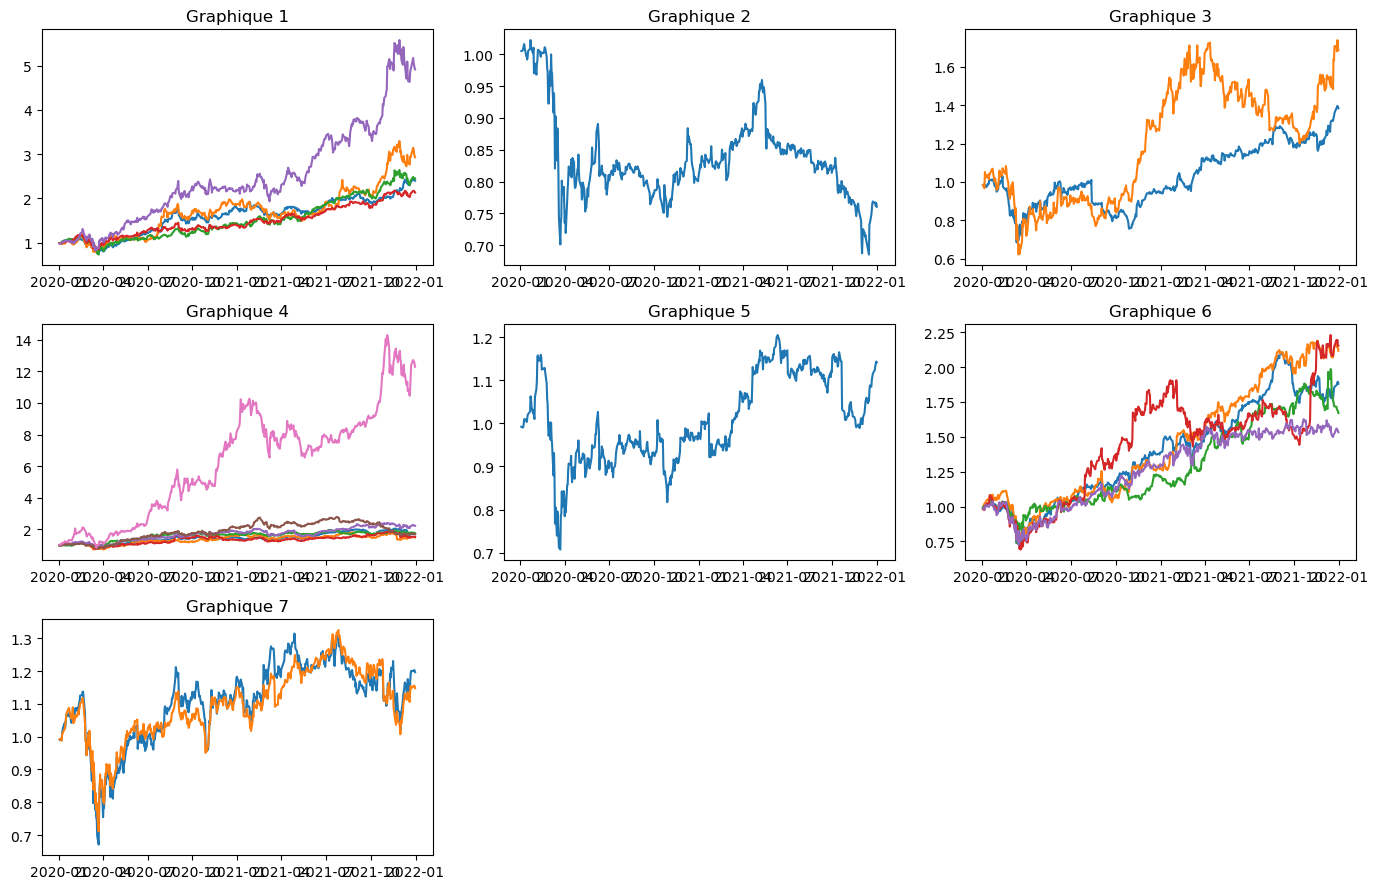

In [5]:
# ======= I. Clustering the universe of assets =======
clusters_list = dtw_clustering(df=train_sample, n_clusters=7)

nb_clusters = len(clusters_list)
print(f'Number of clusters: {nb_clusters}')
# ------- I.1. Plotting the clusters -------
cols = 3
rows = (nb_clusters // cols) + (nb_clusters % cols > 0) 
fig, axes = plt.subplots(rows, cols, figsize=(14, 3 * rows))
axes = axes.flatten()  

for i, df in enumerate(clusters_list):
    df_ret = df.pct_change().dropna()
    df_cumret = (1 + df_ret).cumprod()
    
    ax = axes[i]
    ax.plot(df_cumret)  
    ax.set_title(f"Graphique {i+1}")
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

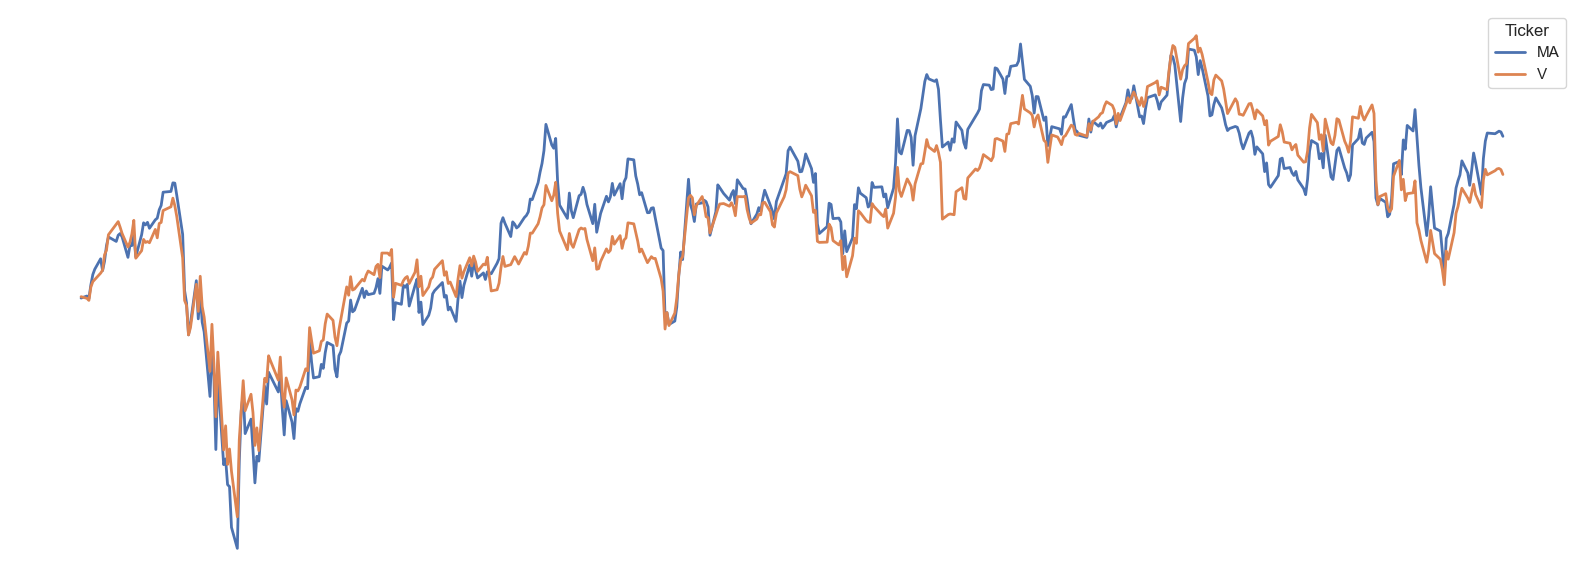

In [16]:
df = clusters_list[6]
df_ret = df.pct_change().dropna()
df_cumret = (1 + df_ret).cumprod()

# Minimalistic plot for cumulative returns
plt.figure(figsize=(16, 6))  # Set an appropriate figure size
df_cumret.plot(ax=plt.gca(), linewidth=2, legend=True)

# Remove unnecessary elements for a clean look
plt.axis('off')  # Hide axes entirely for maximum simplicity
plt.tight_layout()

plt.savefig("cumulative_returns.png", transparent=True, dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


---
# **3. 🔍 Finding Co-integrated Pairs**
To identify pairs of assets that move together over the long term, we use the **Engle-Granger (1985)** 
method to test for **cointegration**. This approach is particularly valuable for pairs trading 
because it not only identifies co-integrated pairs but also provides a model for the **residuals** 
(the difference between the asset prices over time), which is essential for detecting and profiting 
from temporary divergences.

Additionally, the Engle-Granger method calculates **weights for each asset** in the pair, showing the 
appropriate proportion to hold in each. This information allows us to set up a balanced trading 
position that aligns with the long-term relationship between the assets, helping us optimize for 
mean-reversion in our pairs trading strategy.

In [6]:
def generate_combinations(
    df: pd.DataFrame,
    num_assets_per_comb: int,
    max_shared_assets: int,
):
    """
    Generate unique combinations of assets from the dataframe, limiting overlap between combinations.
    Allows certain assets to appear in up to a specified number of combinations.

    Args:
        df (pd.DataFrame): DataFrame of asset price histories.
        num_assets_per_comb (int): Number of assets per combination.
        max_shared_assets (int): Maximum times an asset can be shared across different combinations.

    Returns:
        list_of_dfs (list[pd.DataFrame]): List of DataFrames, each containing one valid combination of assets.
    """
    # ======== I. Compute all possible combinations of assets
    assets = df.columns.tolist()
    all_combinations = list(itertools.combinations(assets, num_assets_per_comb))

    # ======== II. Track how many times each asset appears in selected combinations
    asset_count = {asset: 0 for asset in assets}
    selected_combinations = []

    for combination in all_combinations:
        # -------- Check overlap with already selected combinations
        is_valid_combination = True
        for asset in combination:
            if asset_count[asset] >= max_shared_assets:
                is_valid_combination = False
                break

        # --------- If valid, add the combination and update asset counts
        if is_valid_combination:
            selected_combinations.append(combination)
            for asset in combination:
                asset_count[asset] += 1

    # ======== III. Storing each combination in a list of DataFrames
    list_of_dfs = [df[list(combination)] for combination in selected_combinations]

    return list_of_dfs

In [7]:
# ======= II. Generate combinations of assets for each cluster =======
combinations_list = []
for cluster in clusters_list:
    combination = generate_combinations(df=cluster, num_assets_per_comb=2, max_shared_assets=4)
    combinations_list += combination

nb_combinations = len(combinations_list)
print(f'Number of combinations: {nb_combinations}')

Number of combinations: 33


In [8]:
def linear_regression(df: pd.DataFrame):
    """
    Perform a linear regression on the DataFrame's columns.
    If the DataFrame has n columns, the first column is the dependant variable and the rest are independant variables.
    ALso performs an ADF test on the residuals to check for stationarity.

    Args:
        df (pd.DataFrame): DataFrame of asset price histories

    Returns:
        tuple: Tuple containing the coefficients of the linear regression, the ADF test results, and the residuals.
    """
    # ======== I. Performs the linear regression
    log_df = np.log(df)

    X = log_df.iloc[:, 1:]  # Independant variable(s)
    Y = log_df.iloc[:, 0]  # Dependant variable
    model = LinearRegression()
    model.fit(X, Y)

    # ======== II. Store the results
    coefficients = (
        -model.coef_
    )  # X - bY - intercept = epsilon -> that's why apply a minus sign
    intercept = -model.intercept_

    coefficients_total = np.append(
        [1], coefficients
    )  # Add a 1 in front of the coefficients for the target variable

    coefficients_with_intercept = np.append([intercept], coefficients_total)

    # ---------
    residuals = log_df.dot(coefficients_total) + intercept

    # ---------
    adf_results = adfuller(residuals)
    
    # ---------
    coint_results = {
        "p_value": adf_results[1],
        "coefficients": coefficients_with_intercept,
        "residuals": residuals,
    }

    return coint_results

In [9]:
# ======= III. Check for cointegration in each combination =======
coint_pairs_list = []
for combination in combinations_list:
    coint_results = linear_regression(combination)
    p_value = coint_results["p_value"]
    if p_value < 0.05:
        print(f"Combination {combination.columns.tolist()} is cointegrated with p-value {p_value}")
        pair_information = {
            "combination": combination,
            "coint_results": coint_results,
        }
        coint_pairs_list.append(pair_information)

Combination ['AAPL', 'AMD'] is cointegrated with p-value 0.03538676279740335
Combination ['INTU', 'MSFT'] is cointegrated with p-value 0.02842608288611073
Combination ['ADSK', 'AMZN'] is cointegrated with p-value 0.01797796804008077
Combination ['CRM', 'NOW'] is cointegrated with p-value 0.009921425091989169
Combination ['A', 'GOOGL'] is cointegrated with p-value 0.037363604576245886
Combination ['GOOGL', 'ORCL'] is cointegrated with p-value 0.0012672888496239128


---
# **4. 📈 Apply Signals**
Since the residuals obtained from the Engle-Granger method are stationary, we can assume they follow 
an **Ornstein-Uhlenbeck (OU)** process. The stochastic differential equation (SDE) for the OU process 
is given by:

$$
dX_t = \theta(\mu - X_t)dt + \sigma dW_t
$$

where:
- $X_t$ is the value of the process at time $t$,
- $\mu$ is the long-term mean,
- $\theta$ is the rate of reversion to the mean,
- $\sigma$ is the volatility, and
- $W_t$ is a Wiener process.

We will use this model to compute the **z-score** of the residuals, which allows us to measure how many standard deviations the current residual is from the mean. By applying thresholds to the z-score, we can define clear entry and exit signals for our trading strategy. When the z-score exceeds the upper threshold, it may signal a short position, while crossing the lower threshold could indicate a long position, thus allowing us to effectively capitalize on mean-reverting behavior.



In [10]:
def estimate_ou_parameters(data: np.array):
    """
    Estimate the parameters of an Ornstein-Uhlenbeck process given a time series.

    Parameters:
        data (array-like): A time series of observations (daily observations).

    Returns:
        dict: Estimated parameters of the OU process (mu, theta, sigma, half_life).
    """
    # ======== I. Perform OLS on AR(1)
    mu = np.mean(data)
    delta_data = np.diff(data)

    # ---------
    X = data[:-1] - mu  # X_t - mu
    Y = delta_data  # X_{t+1} - X_t
    reg = sm.OLS(Y, X).fit()

    # ======== II. Estimate parameters
    theta = -reg.params[0]
    if theta > 0:
        residuals = reg.resid
        sigma = np.sqrt(np.std(residuals) * 2 * theta)
        half_life = np.log(2) / theta
    else:
        theta = 0
        sigma = 0
        half_life = 0

    return mu, theta, sigma, half_life

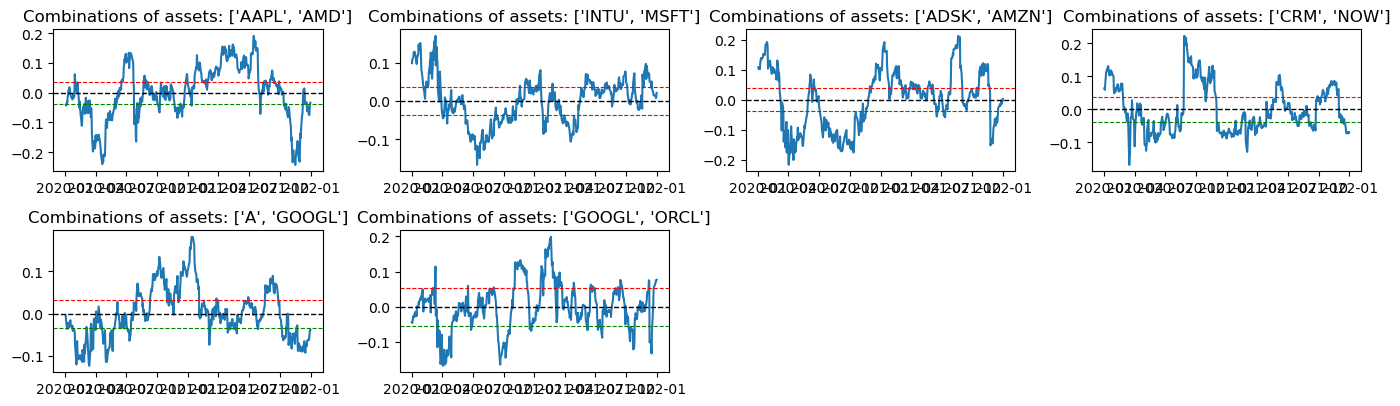

In [11]:
# ======= IV. Estimate OU (Ornstein-Uhlenbeck process) parameters for each cointegrated pair =======
OU_pairs_list = []
for pair in coint_pairs_list:
    combination = pair["combination"]
    coint_results = pair["coint_results"]
    mu, theta, sigma, half_life = estimate_ou_parameters(coint_results['residuals'])

    pair_information = {
        "combination": combination,
        "OU_parameters": {"mu": mu, "theta": theta, "sigma": sigma, "half_life": half_life},
        "coint_results": coint_results,
    }
    OU_pairs_list.append(pair_information)

# ======= IV.bis Plot the residuals of each cointegrated pair in the train_sample =======
cols = 4
rows = (nb_combinations // cols) + (nb_combinations % cols > 0) 
fig, axes = plt.subplots(rows, cols, figsize=(14, 2 * rows))
axes = axes.flatten()  

for i, pair in enumerate(OU_pairs_list):
    residuals = pair['coint_results']['residuals']
    assets_name = pair['combination'].columns.tolist()
    volatility = pair['OU_parameters']['sigma']
    
    ax = axes[i]
    ax.plot(residuals)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, label='0')
    ax.axhline(y=volatility, color='red', linestyle='--', linewidth=0.8, label='Z score = 1')
    ax.axhline(y=-volatility, color='green', linestyle='--', linewidth=0.8, label='Z score = -1')
    ax.set_title(f"Combinations of assets: {assets_name}")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [12]:
def apply_signals(test_sample: pd.DataFrame, pairs: list):
    """
    Apply the mean-reverting trading strategy to the test sample for each cointegrated pair.
    
    Args:
        test_sample (pd.DataFrame): DataFrame of asset price histories for the test sample.
        pairs (list): List of dictionaries, each containing information about a cointegrated pair.
    
    Returns:
        results_list (list): List of DataFrames, each containing the trading signals for a pair.
    """
    # Initialize a list to store results for each pair
    results_list = []

    for pair in pairs:
        # -------- I. Extract the pair information
        assets_name = pair['combination'].columns.tolist()
        weights = pair['coint_results']['coefficients'][1:]
        intercept = pair['coint_results']['coefficients'][0]
        volatility = pair['OU_parameters']['sigma']

        # -------- II. Define the Entry and Exit thresholds
        long_entry = -volatility
        short_entry = volatility
        winning_exit = 0
        long_panic_exit = -2.5 * volatility
        short_panic_exit = 2.5 * volatility

        # -------- III. Compute the log prices and residuals on the test sample
        data = test_sample[assets_name].copy()
        log_data = np.log(data)

        # Store log prices for each asset
        data['log_prices_asset1'] = log_data[assets_name[0]]
        data['log_prices_asset2'] = log_data[assets_name[1]]

        # Calculate residuals
        data['residuals'] = log_data.dot(weights) + intercept
        data['volatility'] = volatility

        # Initialize the signal column
        data['signal'] = 0  # No position initially

        # -------- IV. Implement the trading logic
        position = 0  # Track current position (0 = no position, 1 = long, -1 = short)

        for i, index in enumerate(data.index):
            row = data.loc[index]
            residual = row['residuals']

            # Check if we should enter a position
            if (position ==0) and (residual <= long_entry) and (residual >= long_panic_exit):
                position = 1
            
            elif (position ==0) and (residual >= short_entry) and (residual <= short_panic_exit):
                position = -1
            
            # Check if we should keep a position
            elif (position == 1) and (residual <= long_entry) and (residual >= long_panic_exit):
                position = 1
            
            elif (position == -1) and (residual >= short_entry) and (residual <= short_panic_exit):
                position = -1
            
            # Check if we should exit a position
            elif (position == 1) and (residual >= winning_exit) or (residual <= long_panic_exit):   
                position = 0
                
            elif (position == -1) and (residual <= winning_exit) or (residual >= short_panic_exit):
                position = 0   
            
            data.at[index, 'signal'] = position

        # Append the DataFrame for this pair to the results list
        results_list.append(data)
    
    return results_list

In [13]:
# ======= V. Backtest the pairs trading strategy on the test sample =======
results = apply_signals(test_sample=test_sample, pairs=OU_pairs_list)

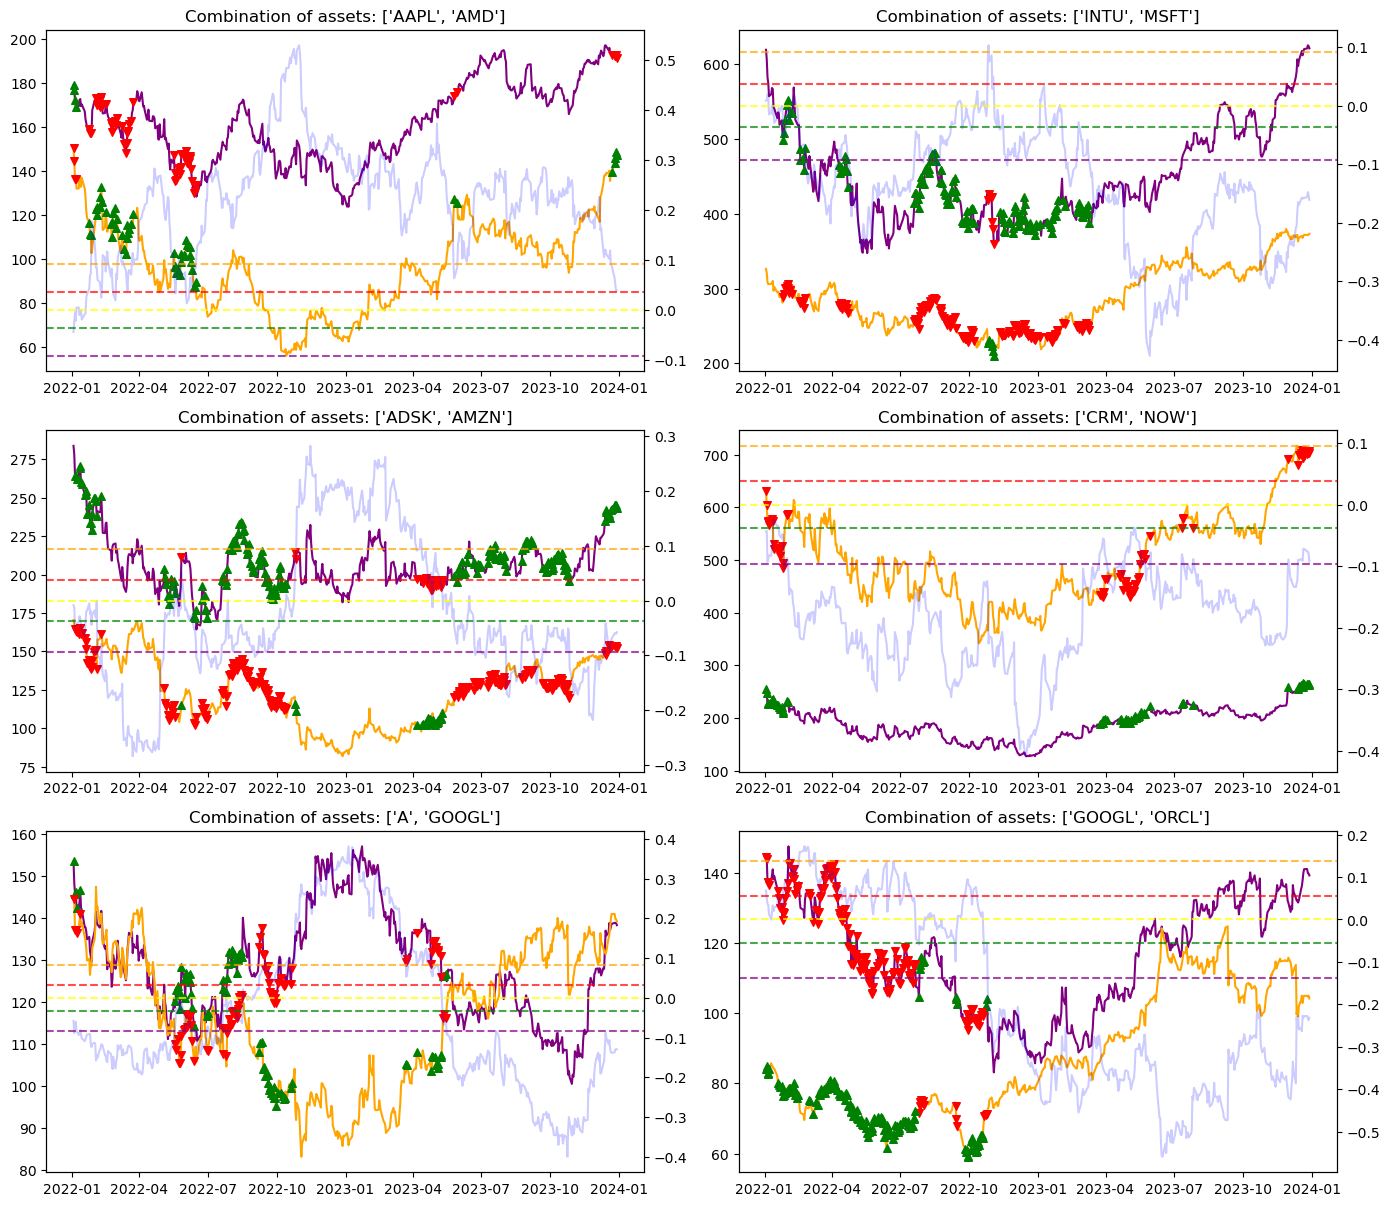

In [14]:
# ======= V.bis Plot the results of the backtest =======
cols = 2
rows = (nb_combinations // cols) + (nb_combinations % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows))
axes = axes.flatten()

for i, result in enumerate(results):
    assets_name = result.columns[:2].tolist()
    asset_1 = result[assets_name[0]]
    asset_2 = result[assets_name[1]]
    
    residuals = result['residuals']
    signal = result['signal']

    ax = axes[i]

    # Plot log prices
    ax.plot(asset_1, label=assets_name[0], color='purple')
    ax.plot(asset_2, label=assets_name[1], color='orange')
    
    # Create a secondary y-axis for residuals
    ax2 = ax.twinx()
    ax2.plot(residuals, label='Residuals', color='blue', alpha=0.2)

    # Add entry and exit thresholds
    long_entry_threshold = -result['volatility'].iloc[0]  # Assuming this is how you're calculating it
    short_entry_threshold = result['volatility'].iloc[0]
    winning_exit_threshold = 0
    long_panic_exit_threshold = -2.5 * result['volatility'].iloc[0]
    short_panic_exit_threshold = 2.5 * result['volatility'].iloc[0]

    ax2.axhline(y=long_entry_threshold, color='green', linestyle='--', label='Long Entry Threshold', alpha=0.7)
    ax2.axhline(y=short_entry_threshold, color='red', linestyle='--', label='Short Entry Threshold', alpha=0.7)
    ax2.axhline(y=winning_exit_threshold, color='yellow', linestyle='--', label='Winning Exit Threshold', alpha=0.7)
    ax2.axhline(y=long_panic_exit_threshold, color='purple', linestyle='--', label='Long Panic Exit Threshold', alpha=0.7)
    ax2.axhline(y=short_panic_exit_threshold, color='orange', linestyle='--', label='Short Panic Exit Threshold', alpha=0.7)

    # Add signals to the log prices plot
    long_signals = result[signal == 1].index
    short_signals = result[signal == -1].index

    # Long signal on asset 1
    ax.scatter(long_signals, asset_1[long_signals], color='green', marker='^', label='Long Signal Asset 1', s=30, zorder=5)
    # Short signal on asset 2
    ax.scatter(long_signals, asset_2[long_signals], color='red', marker='v', label='Short Signal Asset 2', s=30, zorder=5)

    # Long signal on asset 2
    ax.scatter(short_signals, asset_2[short_signals], color='green', marker='^', label='Long Signal Asset 2', s=30, zorder=5)
    # Short signal on asset 1
    ax.scatter(short_signals, asset_1[short_signals], color='red', marker='v', label='Short Signal Asset 1', s=30, zorder=5)

    ax.set_title(f"Combination of assets: {assets_name}")

    # Combine legends from both axes
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [15]:
def calculate_strategy_returns(df: pd.DataFrame):
    """
    Compute the strategy returns based on the trading signals and asset returns.
    
    Args:
        df (pd.DataFrame): DataFrame containing the trading signals and asset returns.
    
    Returns:
        strategy_returns (pd.Series): Series containing the returns of the strategy
    """
    
    asset1_col = df.columns[0]
    asset2_col = df.columns[1]
    
    df['return_asset1'] = df[asset1_col].pct_change()
    df['return_asset2'] = df[asset2_col].pct_change()
    
    strategy_returns = df['signal'].shift(1) * (df['return_asset1'] - df['return_asset2'])
    
    return strategy_returns

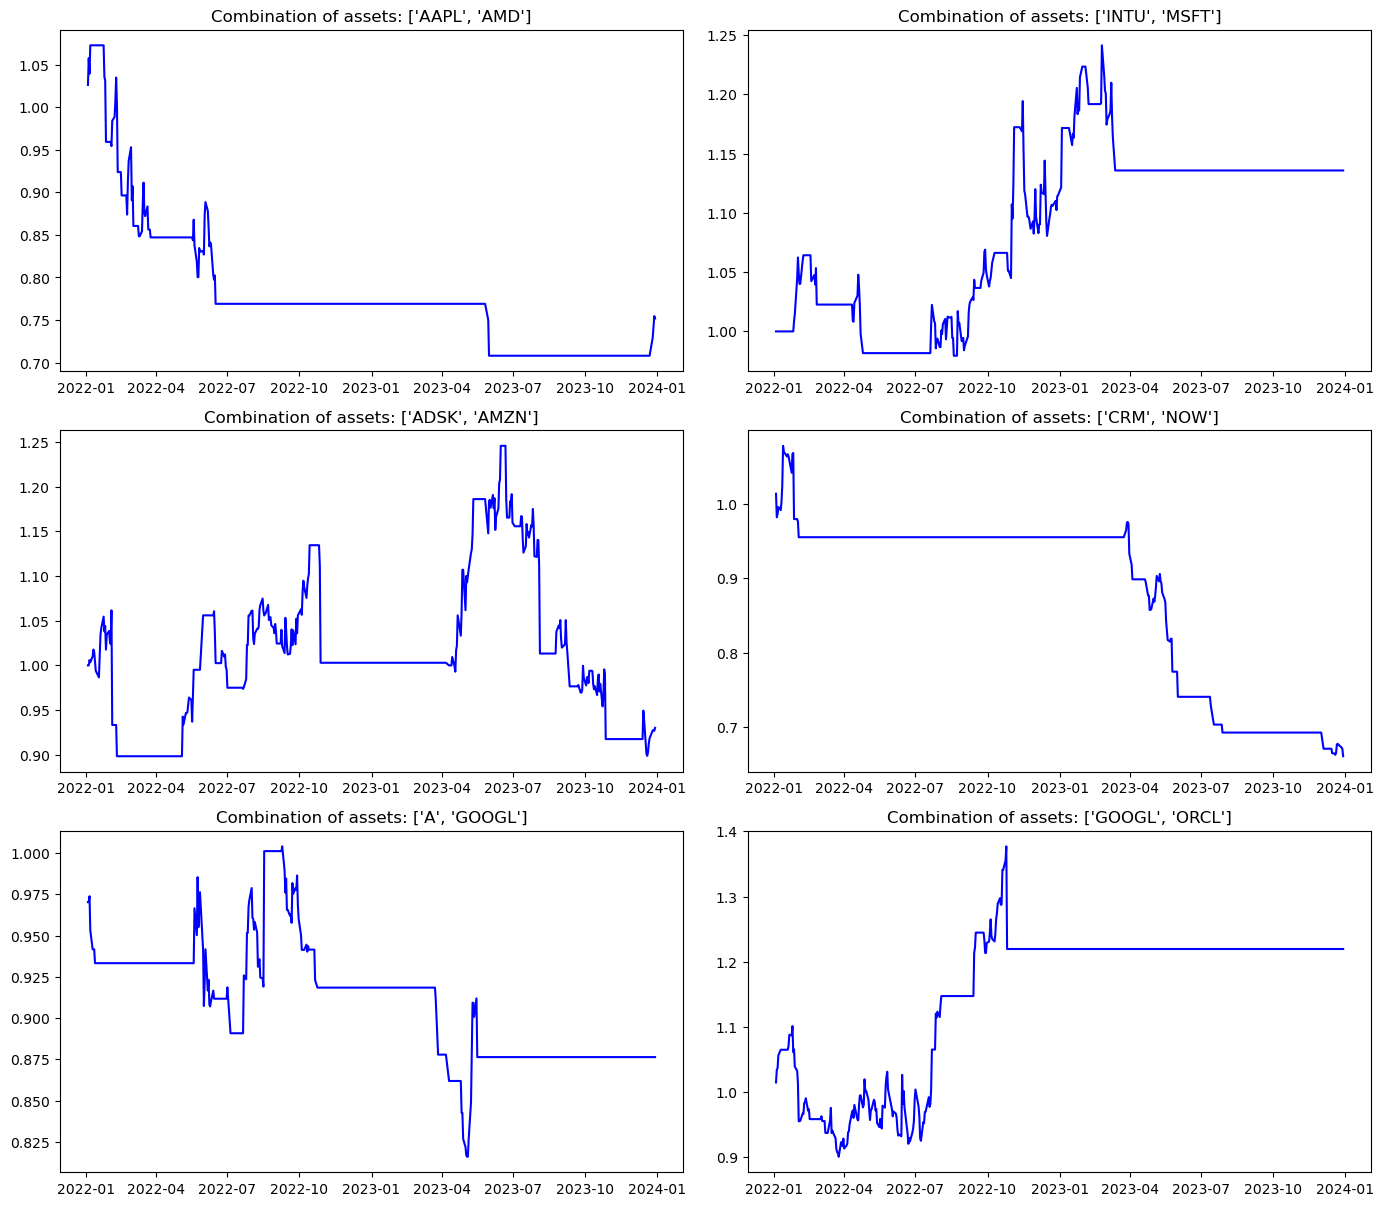

In [16]:
# ======= VI. Compute the cumulative returns of the strategy =======
for i, result in enumerate(results):
    strategy_returns = calculate_strategy_returns(result)
    result['strategy_returns'] = strategy_returns
    result['cumulative_strategy_returns'] = (1 + result['strategy_returns']).cumprod()

# ======= VI.bis Plot the cumulative returns of the strategy =======
cols = 2
rows = (nb_combinations // cols) + (nb_combinations % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows))
axes = axes.flatten()

for i, result in enumerate(results):
    assets_name = result.columns[:2].tolist()
    cumulative_strategy_returns = result['cumulative_strategy_returns']
    
    ax = axes[i]
    ax.plot(cumulative_strategy_returns, label='Cumulative Strategy Returns', color='blue')
    ax.set_title(f"Combination of assets: {assets_name}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()